In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Read job logs

In [3]:
job_logs = pd.read_parquet('job_logs.parquet.gz')

## Unique jobs per batch class

In [4]:
grouped = job_logs.groupby(["Queue"])

In [5]:
grouped["Identifier"].nunique()/grouped["Identifier"].nunique().sum()*100

Queue
clbigmem     1.375565
clexpres     3.601509
clfo2        2.973887
cllong       3.694189
clmedium    77.098306
feque       11.256545
Name: Identifier, dtype: float64

## Job prevalence per batch class

In [7]:
grouped["Queue"].count()/job_logs["Queue"].count()*100

Queue
clbigmem     2.096751
clexpres     0.905538
clfo2        5.591450
cllong      24.335098
clmedium    64.375874
feque        2.695289
Name: Queue, dtype: float64

Job load is particularly high for the clmedium and cllong queues, but also for the clfo2 part of the HPC system. Moderate job loads are observed for the vequeue, feque and clbigmem queues. Very low job loads are observed for the veexpres queue, nearly no job load for the clexpres, clintera, veintera and cltestque queues.

## Job status prevalence
We cannot access exact
The logging script only collects job scheduler snapshots at a ten minute resolution. We have to estimate job ch

In [10]:
grouped = job_logs.groupby("STT")

In [11]:
grouped["Time"].count()/request_logs["Time"].count()*100

STT
EXT     0.037517
HLD     0.101782
POR     0.013548
PRR     0.007851
QUE    56.385882
RUN    43.340939
STG     0.008719
WAT     0.103762
Name: Time, dtype: float64

About 99.7% of the jobs are either in a QUE or RUN state. To simplify the analysis we estimate job characteristics without considering other potential states.

## Estimate job characteristics

In [14]:
grouped = request_logs.groupby(["STT", "Identifier"])
df = grouped.count()

In [15]:
df = df[["Queue"]].unstack(level=0)["Queue"]

In [16]:
keep_id = df.where((df["QUE"] > 0) & (df["RUN"] > 0)).dropna().index

In [17]:
cleaned = request_logs.set_index("Identifier").loc[keep_id]

In [18]:
running_jobs = cleaned["STT"] == "RUN"
grouped_running = cleaned[running_jobs].groupby("Identifier")

In [19]:
queued_jobs = cleaned["STT"] == "QUE"
grouped_queued = cleaned[queued_jobs].groupby("Identifier")

In [23]:
job_stats = pd.DataFrame(
    dict(queue=grouped_running["Queue"].unique(),
         waited=(grouped_queued["Time"].max()
                 -grouped_queued["Time"].min()).dt.total_seconds()/60, # in minutes
         duration=grouped_running["Elapse"].max(),
         cpu=grouped_running["CPU_occ"].mean(),
         memory=grouped_running["Memory"].mean(),
    )
)

In [24]:
job_stats

,queue,waited,duration,cpu,memory
Identifier,,,,,
000030ecd19c9c04,[feque],20.641710,1.450000,0.168851,0.313490
00027e89035bec8d,[clmedium],30.044835,1.283333,21.721169,131.760000
00044e0a50d292e0,[clmedium],20.662978,5.766667,29.034220,2.490000
0005bc60f93ebf7f,[clmedium],761.864516,100.766667,28.123996,1.866537
0005f3be12f14ee2,[feque],536.759766,11.500000,0.005048,0.227640
...,...,...,...,...,...
ffef9fe968899775,[clexpres],343.294192,6.883333,29.522760,23.560000
fff1eb76162c6027,[feque],31.959300,1.316667,0.249114,0.297420
fff7ad56f879ba6b,[cllong],402.363422,177.750000,31.128994,2.137778


In [36]:
job_stats["queue"]

Identifier
000030ecd19c9c04       [feque]
00027e89035bec8d    [clmedium]
00044e0a50d292e0    [clmedium]
0005bc60f93ebf7f    [clmedium]
0005f3be12f14ee2       [feque]
                       ...    
ffef9fe968899775    [clexpres]
fff1eb76162c6027       [feque]
fff7ad56f879ba6b      [cllong]
fff9d98fe020471f    [clmedium]
fffabf82e38ce12d    [clmedium]
Name: queue, Length: 16757, dtype: object

We assume that jobs with a duration of less than two minutes aborted and remove them.


Text(0.5, 0, 'Elapse time in minutes')

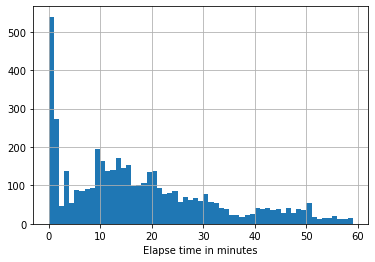

In [47]:
plt.figure(); (job_stats["duration"]).hist(bins=np.arange(0,60,1))
plt.xlabel('Elapse time in minutes')

In [48]:
job_stats = job_stats.where(job_stats["duration"]>2.0)

Text(0.5, 0, 'Elapse time in minutes')

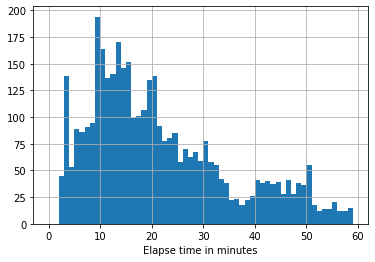

In [49]:
plt.figure(); (job_stats["duration"]).hist(bins=np.arange(0,60,1))
plt.xlabel('Elapse time in minutes')

## Do actual statistics

In [56]:
these_queues = ["feque", "clexpres", "clmedium", "cllong", "clbigmem", "clfo2"]

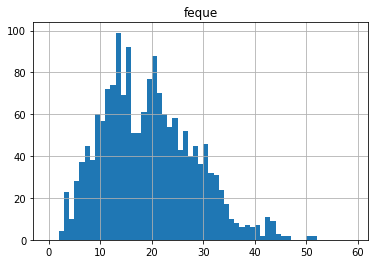

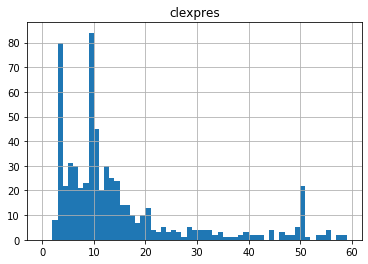

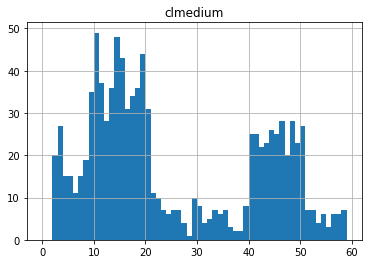

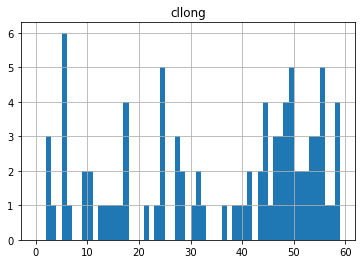

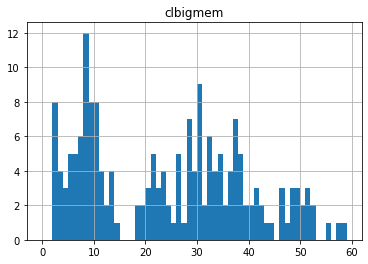

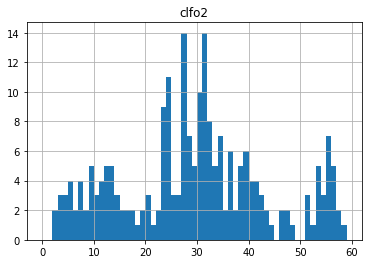

In [57]:
for this_queue in these_queues:
    plt.figure(); plt.title(this_queue)
    job_stats["duration"].where(job_stats["queue"]==this_queue).hist(bins=np.arange(0,60,1))

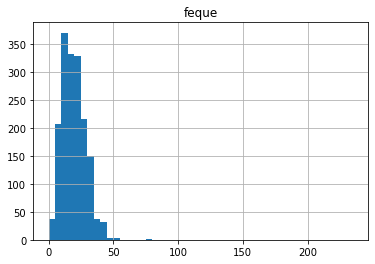

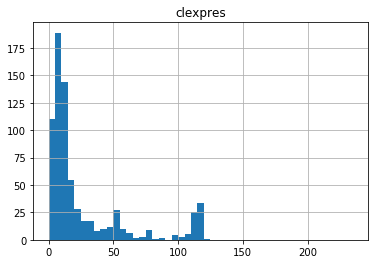

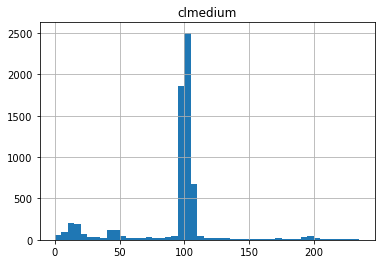

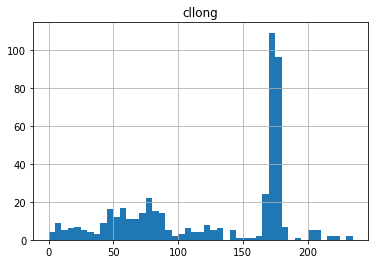

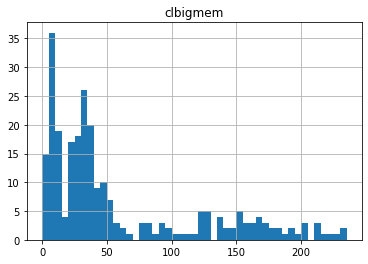

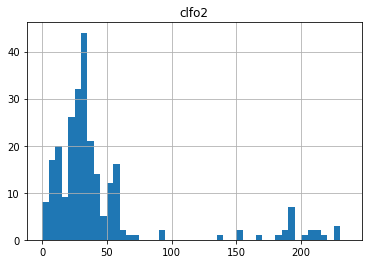

In [60]:
for this_queue in these_queues:
    plt.figure(); plt.title(this_queue)
    job_stats["duration"].where(job_stats["queue"]==this_queue).hist(bins=np.arange(0,240,5))

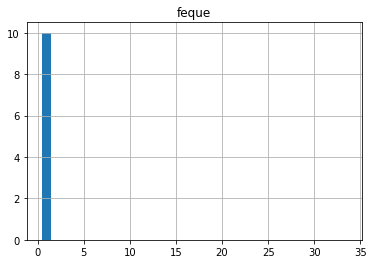

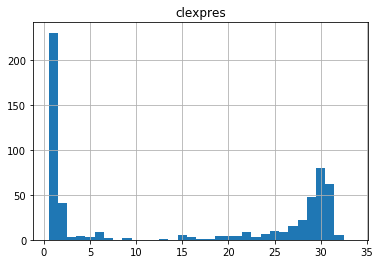

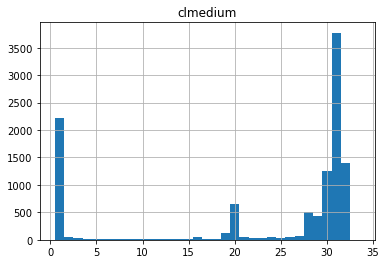

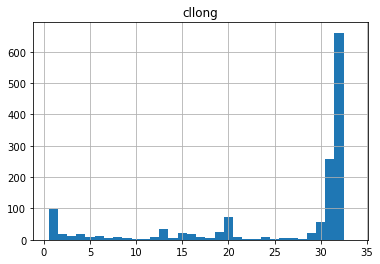

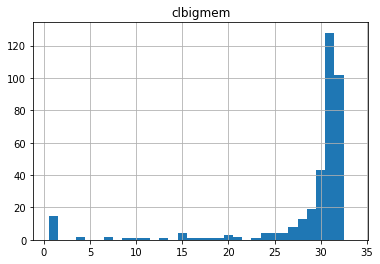

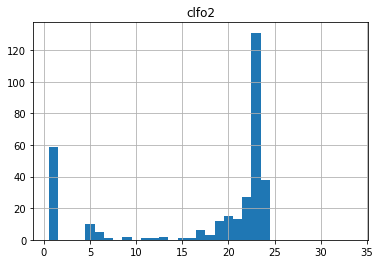

In [61]:
for this_queue in these_queues:
    plt.figure(); plt.title(this_queue)
    job_stats["cpu"].where(job_stats["queue"]==this_queue).hist(bins=np.arange(0.5,33.9,1))

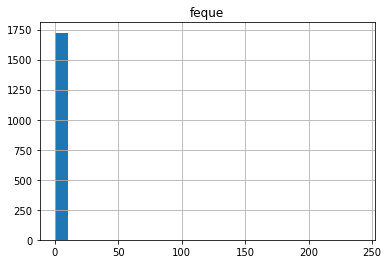

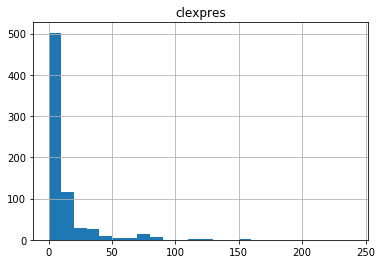

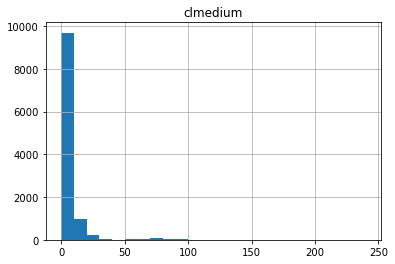

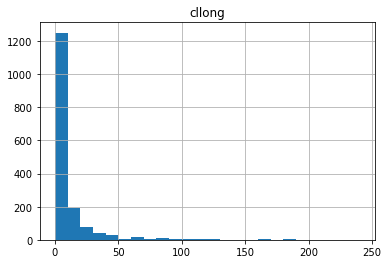

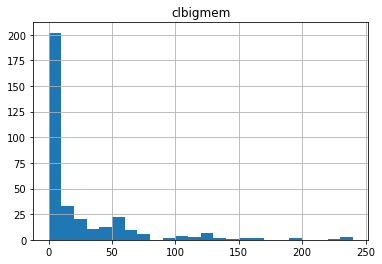

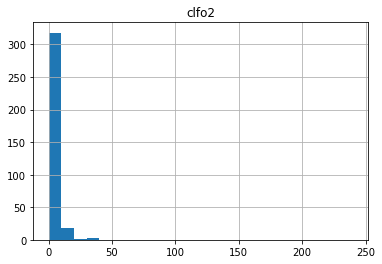

In [63]:
for this_queue in these_queues:
    plt.figure(); plt.title(this_queue)
    job_stats["memory"].where(job_stats["queue"]==this_queue).hist(bins=np.arange(0,250,10))

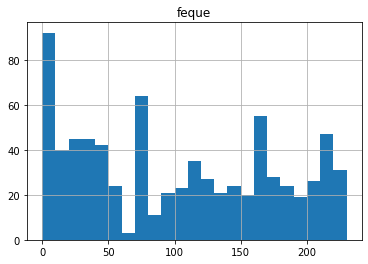

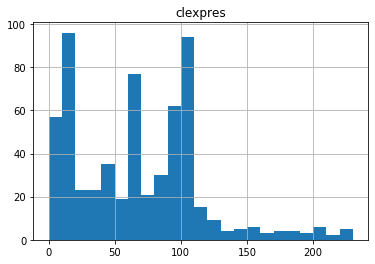

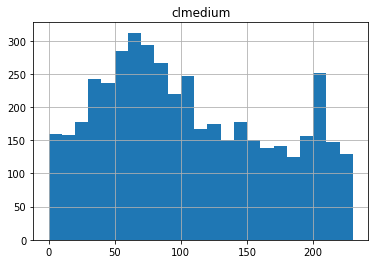

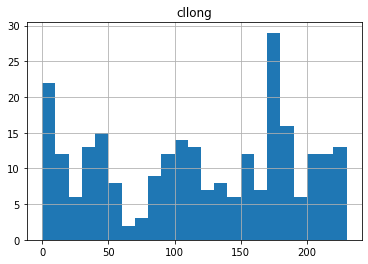

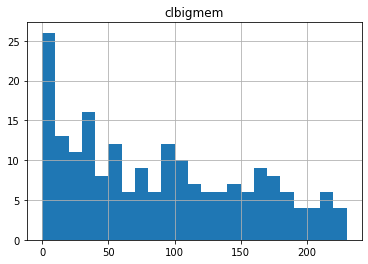

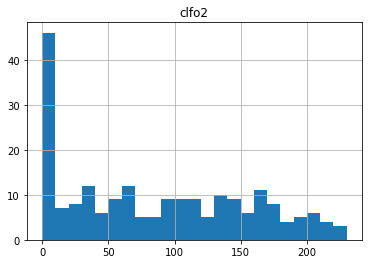

In [66]:
for this_queue in these_queues:
    plt.figure(); plt.title(this_queue)
    job_stats["waited"].where(job_stats["queue"]==this_queue).hist(bins=np.arange(0,240,10))

In [71]:
job_stats["cpu"].where(job_stats["queue"]==this_queue).dropna()

Identifier
0005f3be12f14ee2    0.005048
005ffcbe0f25b85c    0.012840
0073985469b99a91    0.154940
00ac9c839f3968be    0.070943
00ae6c6846006f4b    0.000011
                      ...   
fea30585cbd70247    0.000016
ffda13669401c4d0    0.057105
ffdda6cdfec58cd9    0.161703
ffdf3c33facdaaa6    0.118521
ffe5e2d4c82c4467    0.128178
Name: cpu, Length: 1724, dtype: float64

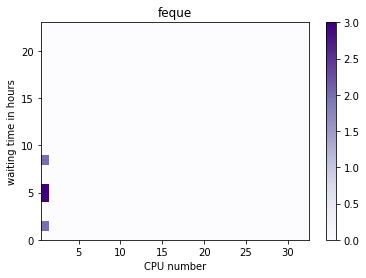

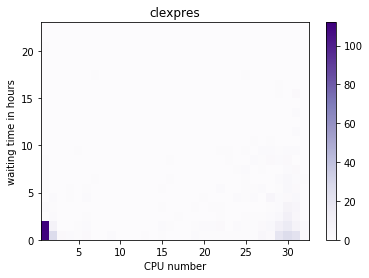

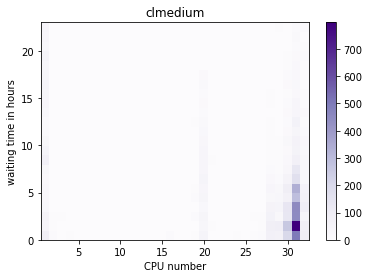

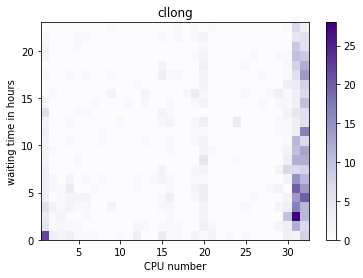

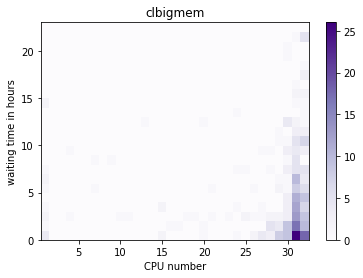

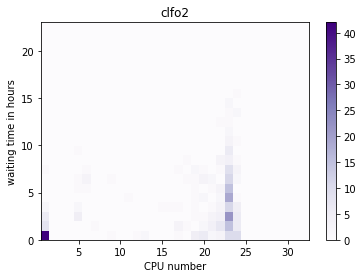

In [85]:
for this_queue in these_queues:
    plt.figure(); plt.title(this_queue)
    plt.hist2d(job_stats["cpu"].where(job_stats["queue"]==this_queue).dropna(), 
             job_stats["waited"].where(job_stats["queue"]==this_queue).dropna()/60,
             cmap='Purples', bins=[np.arange(0.5,33,1),np.arange(0,24,1)]) # gridsize=(32,10), 
    plt.colorbar(); plt.xlabel("CPU number"); plt.ylabel("waiting time in hours")

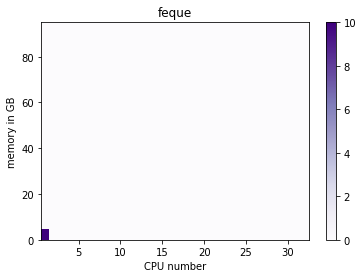

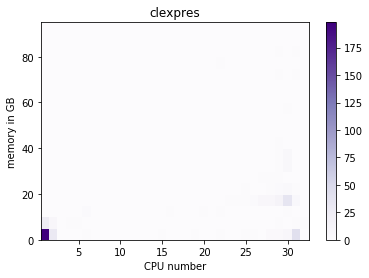

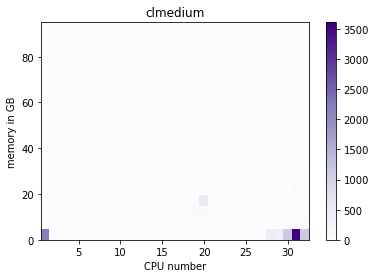

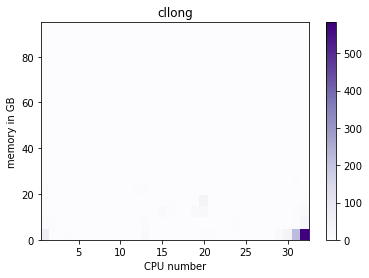

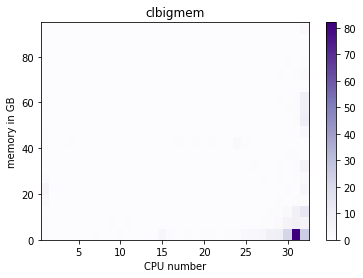

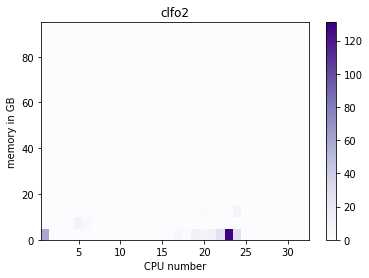

In [87]:
for this_queue in these_queues:
    plt.figure(); plt.title(this_queue)
    plt.hist2d(job_stats["cpu"].where(job_stats["queue"]==this_queue).dropna(), 
             job_stats["memory"].where(job_stats["queue"]==this_queue).dropna(),
             cmap='Purples', bins=[np.arange(0.5,33,1),np.arange(0,100,5)]) # gridsize=(32,10), 
    plt.colorbar(); plt.xlabel("CPU number"); plt.ylabel("memory in GB")

Text(0.5, 0, 'Elapse time in minutes')

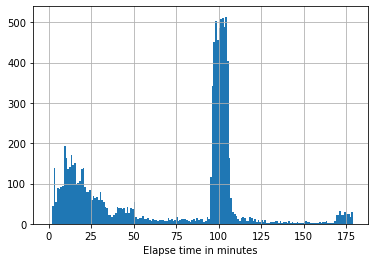

In [39]:
plt.figure(); (job_stats["duration"]).hist(bins=np.arange(0,180,1))
plt.xlabel('Elapse time in minutes')

In [69]:
job_stats["duration"].max()/60

199.92333333333332

Text(0.5, 0, 'Elapse time in minutes')

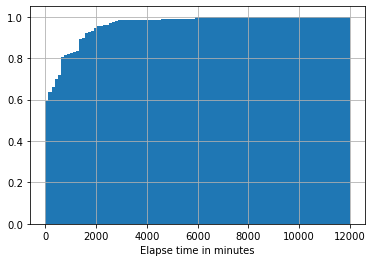

In [67]:
plt.figure(); (job_stats["duration"]).hist(bins=100, cumulative=True, density=True)
plt.xlabel('Elapse time in minutes')

Text(0.5, 0, 'Elapse time in hours')

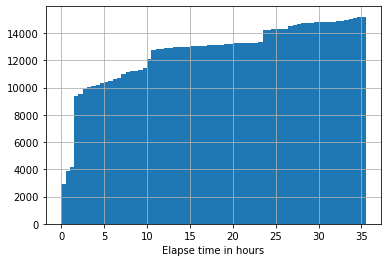

In [65]:
plt.figure(); (job_stats["duration"]/60).hist(bins=np.arange(0,1.5*24,0.5),cumulative=True)
plt.xlabel('Elapse time in hours')

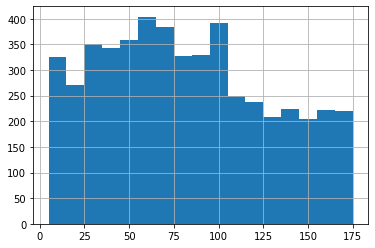

In [56]:
plt.figure(); job_stats["waited"].hist(bins=np.arange(5,180,10))

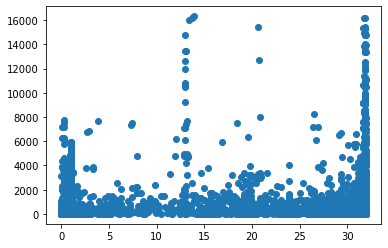

In [59]:
plt.plot(job_stats["cpu"], job_stats["waited"], 'o')

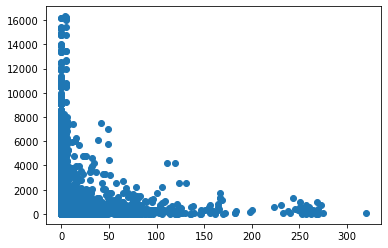

In [60]:
plt.plot(job_stats["memory"], job_stats["waited"], 'o')

Text(0.5, 0, 'Elapse time in hours')

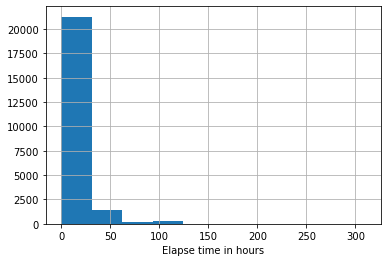

In [181]:
plt.figure(); job_stats["duration"].hist() # bins=np.arange(0,24*3,2)
plt.xlabel('Elapse time in hours')

Text(0.5, 0, 'Elapse time in hours')

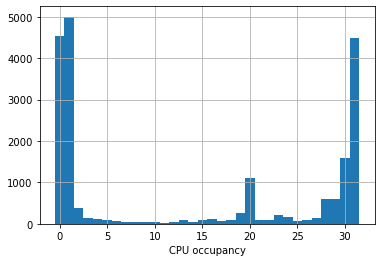

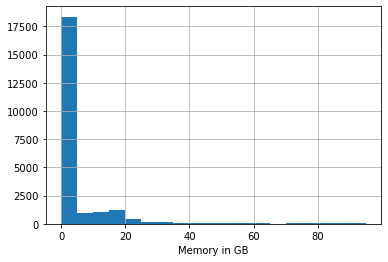

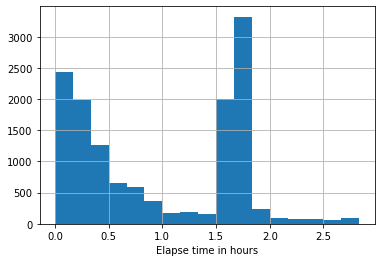

In [182]:
plt.figure(); job_stats["cpu"].hist(bins=np.arange(-0.5,32.5,1))
plt.xlabel('CPU occupancy')

plt.figure(); job_stats["memory"].hist(bins=range(0,100,5))
plt.xlabel('Memory in GB')

plt.figure(); job_stats["duration"].hist(bins=np.arange(0,3,10/60))
plt.xlabel('Elapse time in hours')

#plt.figure(); (grouped["Elapse"].max()*60).hist(bins=np.arange(0,60,1))
#plt.xlabel('Elapse time in minutes')

In [38]:
grouped = request_logs.groupby(['STT', 'Identifier'])

In [ ]:
grouped[]

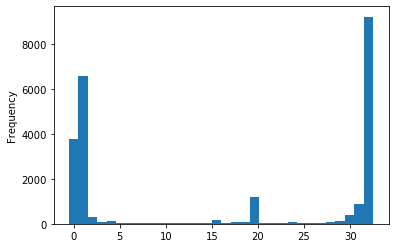

In [39]:
grouped["CPU_occ"].max()["RUN"].plot.hist(range=(-0.5,32.5),bins=32)

In [17]:
grouped["Elapse"].max()

STT  Identifier      
EXT  00a78e790cd01148    0.0
     00d27de6070b8f9a    0.0
     0163207c75ca6935    0.0
     01acfbfc01b88a29    0.0
     02f9eb4842c8a14d    0.0
                        ... 
WAT  dc64bc9a77f5c412    0.0
     df036ac996c30b0b    0.0
     e5c2082fd3f9ef9e    0.0
     f13faa42dbd7a820    0.0
     f79bbed34f78b6c6    0.0
Name: Elapse, Length: 69140, dtype: float64

In [ ]:
# https://realpython.com/pandas-groupby/

In [222]:
grouped = request_logs.groupby(['STT', 'Identifier'])

In [214]:
#grouped = request_logs.groupby(['STT','Identifier'])

In [223]:
request_logs["STT"].unique()

array(['RUN', 'QUE', 'POR', 'PRR', 'STG', 'EXT', 'HLD'], dtype=object)

In [224]:
grouped["Memory"].max()

STT  Identifier      
EXT  00d27de6070b8f9a    0.0
     0163207c75ca6935    0.0
     01acfbfc01b88a29    0.0
     05a119521a207b3d    0.0
     060f74e52f3e00f2    0.0
                        ... 
STG  fa609cc0fafa4045    0.0
     fced5925ce647680    0.0
     fd5a60f1ddafa59c    0.0
     fdad85c8f2153021    0.0
     feae34a73d03ec3e    0.0
Name: Memory, Length: 48190, dtype: float64

In [225]:
grouped["Elapse"].max()["RUN"]

Identifier
00044e0a50d292e0     0.096111
00076c148e19768c    29.319722
000c3234e7b9c898     3.253611
000fd86c40edf54e    10.373889
00167d2208df3340     0.023889
                      ...    
ffef9fe968899775     0.114722
fff1878c0f93e229     0.010833
fff7fe19176ca223     0.017500
fff8ce79d3e39e01    23.676111
fff9d98fe020471f     1.747500
Name: Elapse, Length: 12989, dtype: float64

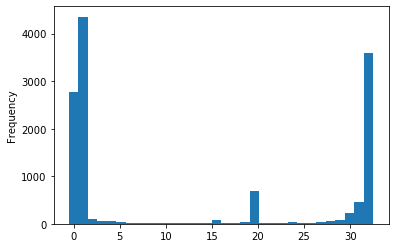

In [226]:
grouped["CPU_occ"].max()["RUN"].plot.hist(range=(-0.5,32.5),bins=32)

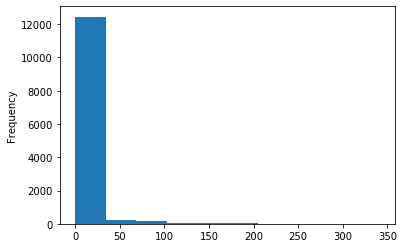

In [229]:
grouped["Memory"].max()["RUN"].plot.hist(bins=10)

In [188]:
grouped["CPU_occ"].max()["RUN"].plot.hist(range=[1,32],bins=32)

KeyError: 'RUN'

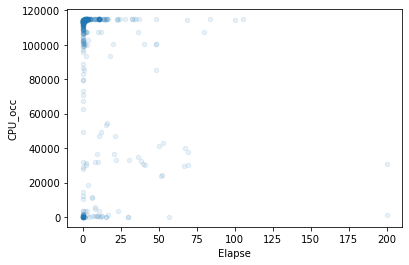

In [189]:
grouped[["CPU_occ", "Elapse"]].max().plot.scatter(
    x="Elapse", y="CPU_occ", alpha=0.1
);

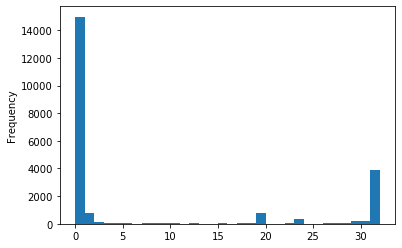

In [32]:
grouped["CPU_occ"].max().plot.hist(range=[0.0,32],bins=32)

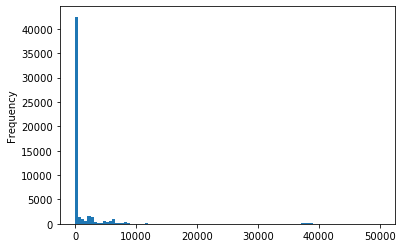

In [33]:
grouped["Elapse"].max().plot.hist(range=[0.0,50000],bins=100)

In [116]:
grouped = request_logs.groupby(['Identifier'])

,Queue,STT,Memory,CPU,Elapse,Identifier,Time,CPU_occ
1,clbigmem,RUN,66.43,1461501.36,181504.0,1cadd9af115874fc,2020-02-06 19:53:10.870544,8.052172
1,clbigmem,RUN,66.43,1481479.31,182141.0,1cadd9af115874fc,2020-02-06 20:03:47.891211,8.133695
1,clbigmem,RUN,66.43,1502427.89,182779.0,1cadd9af115874fc,2020-02-06 20:14:25.878196,8.219915
1,clbigmem,RUN,66.43,1522492.52,183422.0,1cadd9af115874fc,2020-02-06 20:25:09.186588,8.300490
1,clbigmem,RUN,66.43,1542360.96,184061.0,1cadd9af115874fc,2020-02-06 20:35:48.288514,8.379618
...,...,...,...,...,...,...,...,...
0,clbigmem,RUN,66.43,1144060.53,717310.0,1cadd9af115874fc,2020-02-13 00:43:16.934880,1.594932
0,clbigmem,RUN,66.43,1164064.30,717951.0,1cadd9af115874fc,2020-02-13 00:53:58.110439,1.621370
0,clbigmem,RUN,66.43,1184997.57,718590.0,1cadd9af115874fc,2020-02-13 01:04:37.728065,1.649059
0,clbigmem,RUN,66.43,1205005.16,719224.0,1cadd9af115874fc,2020-02-13 01:15:11.295813,1.675424


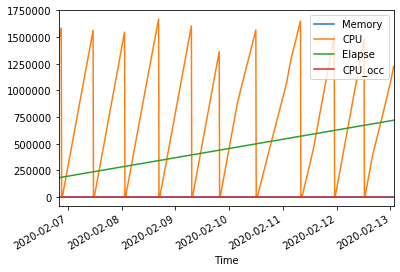

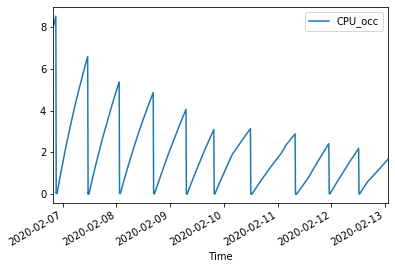

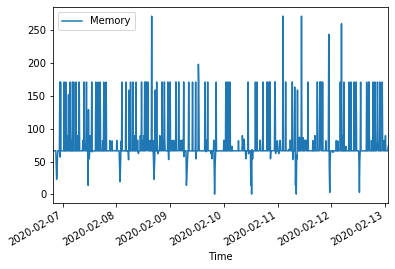

In [118]:
ide = '1cadd9af115874fc'
grouped.get_group(ide).set_index('Time').plot() #.plot(x='Time', y='CPU_acc')
grouped.get_group(ide).set_index('Time').plot(y='CPU_occ')
grouped.get_group(ide).set_index('Time').plot(y='Memory')
grouped.get_group(ide)

In [7]:
!conda list --explicit

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: linux-64
@EXPLICIT
https://conda.anaconda.org/conda-forge/linux-64/_libgcc_mutex-0.1-main.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/ca-certificates-2019.11.28-hecc5488_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/ld_impl_linux-64-2.33.1-h53a641e_7.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgfortran-ng-7.3.0-hdf63c60_2.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libstdcxx-ng-9.2.0-hdf63c60_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgcc-ng-9.2.0-hdf63c60_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/bzip2-1.0.8-h516909a_2.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/expat-2.2.5-he1b5a44_1004.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/icu-64.2-he1b5a44_1.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/jpeg-9c-h14c3975_1001.tar.bz2
https://conda.anaconda.org/c